Load image

In [ ]:
from PIL import Image
import os
import numpy as np

# Load images from the three classes
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            file_path = os.path.join(folder_path, filename)
            try:
                image = Image.open(file_path).convert("RGB")  # Convert to RGB
                image_array = np.array(image)
                images.append(image_array)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# Paths to folders
benign_path = os.path.join("Cleaned Breast Cancer Class", "benign")
malignant_path = os.path.join("Cleaned Breast Cancer Class", "malignant")
normal_path = os.path.join("Cleaned Breast Cancer Class", "normal")

# Load images
benign_images = load_images(benign_path)
malignant_images = load_images(malignant_path)
normal_images = load_images(normal_path)

# Print the counts
print(f"Loaded {len(benign_images)} benign images.")
print(f"Loaded {len(malignant_images)} malignant images.")
print(f"Loaded {len(normal_images)} normal images.")


Loaded 437 benign images.
Loaded 420 malignant images.
Loaded 399 normal images.


In [2]:
# Convert images to tensors
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT
])

benign_tensors = [transform(Image.fromarray(img)) for img in benign_images]
malignant_tensors = [transform(Image.fromarray(img)) for img in malignant_images]
normal_tensors = [transform(Image.fromarray(img)) for img in normal_images]

# Create labels
benign_labels = [0] * len(benign_tensors)
malignant_labels = [1] * len(malignant_tensors)
normal_labels = [2] * len(normal_tensors)

# Combine tensors and labels
all_images = benign_tensors + malignant_tensors + normal_tensors
all_labels = benign_labels + malignant_labels + normal_labels

print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")


Total images: 1256, Total labels: 1256


Split into Train, Validation, and Test Sets

In [3]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Split temp into validation (10%) and test (10%)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")


Training set: 1004 images
Validation set: 126 images
Test set: 126 images


Create PyTorch DataLoaders

In [4]:
from torch.utils.data import DataLoader, Dataset

class BreastCancerDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create datasets
train_dataset = BreastCancerDataset(train_images, train_labels)
val_dataset = BreastCancerDataset(val_images, val_labels)
test_dataset = BreastCancerDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Load Pretrained ViT Model

In [5]:
from transformers import ViTForImageClassification

# Load pretrained model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=3  # 3 classes: benign, malignant, normal
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Define Optimizer and Loss Function

In [6]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()


Training and Validation Loop

In [7]:
from tqdm import tqdm

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        images, labels = images.to(device), labels.to(device)  # No torch.stack needed
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute accuracy
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1} - Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Compute accuracy
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
    print(f"Epoch {epoch + 1} - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Epoch 1 - Train Loss: 0.7370, Train Acc: 0.7122
Epoch 1 - Val Loss: 0.4091, Val Acc: 0.8730


Epoch 2 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Epoch 2 - Train Loss: 0.3181, Train Acc: 0.9004
Epoch 2 - Val Loss: 0.5380, Val Acc: 0.8175


Epoch 3 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


Epoch 3 - Train Loss: 0.1826, Train Acc: 0.9522
Epoch 3 - Val Loss: 0.4316, Val Acc: 0.8730


Epoch 4 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 4 - Train Loss: 0.0880, Train Acc: 0.9841
Epoch 4 - Val Loss: 0.1928, Val Acc: 0.9365


Epoch 5 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch 5 - Train Loss: 0.0676, Train Acc: 0.9871
Epoch 5 - Val Loss: 0.3326, Val Acc: 0.8968


Epoch 6 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch 6 - Train Loss: 0.0621, Train Acc: 0.9910
Epoch 6 - Val Loss: 0.2569, Val Acc: 0.9286


Epoch 7 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


Epoch 7 - Train Loss: 0.1039, Train Acc: 0.9721
Epoch 7 - Val Loss: 0.3593, Val Acc: 0.8968


Epoch 8 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 8 - Train Loss: 0.0467, Train Acc: 0.9880
Epoch 8 - Val Loss: 0.2188, Val Acc: 0.9365


Epoch 9 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch 9 - Train Loss: 0.0501, Train Acc: 0.9890
Epoch 9 - Val Loss: 0.2682, Val Acc: 0.9286


Epoch 10 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Epoch 10 - Train Loss: 0.0362, Train Acc: 0.9940
Epoch 10 - Val Loss: 0.2402, Val Acc: 0.9524


Evaluate on Test Set

In [8]:
# Testing phase
model.eval()
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)  # No torch.stack needed

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        # Compute accuracy
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

Test Loss: 0.3580, Test Accuracy: 0.9206


Generating Predictions: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.9286    0.8864    0.9070        44
           1     0.9500    0.9048    0.9268        42
           2     0.8864    0.9750    0.9286        40

    accuracy                         0.9206       126
   macro avg     0.9216    0.9220    0.9208       126
weighted avg     0.9223    0.9206    0.9204       126



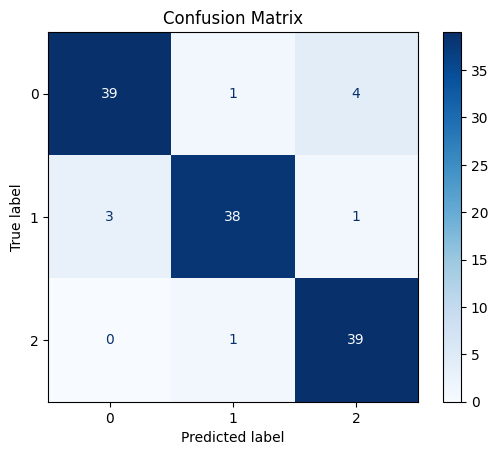

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize arrays to store true and predicted labels
all_labels, all_preds = [], []

# Model in evaluation mode
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating Predictions"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass and predictions
        outputs = model(images)
        preds = outputs.logits.argmax(dim=1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualization of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


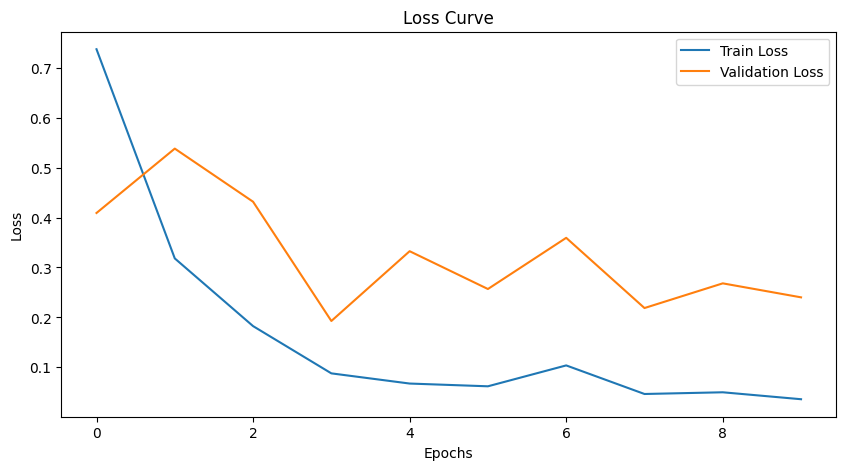

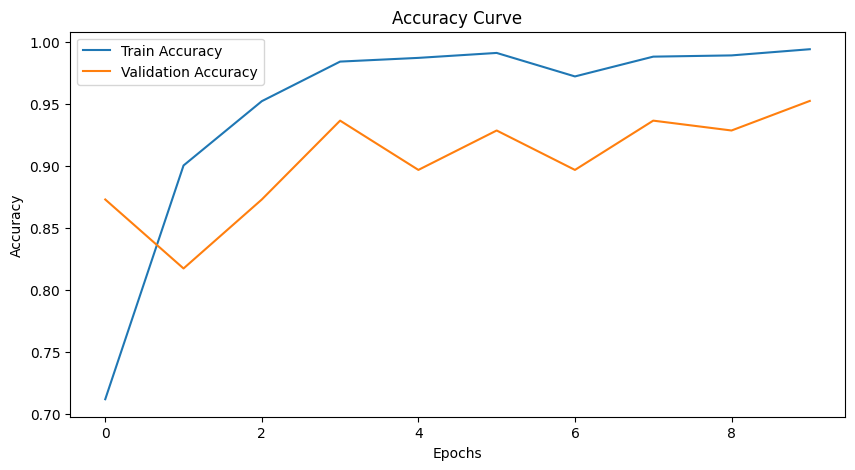

In [10]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [11]:
# Save the model
model_save_path = "vit_breast_cancer_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to vit_breast_cancer_model.pth


Test Unseen image

In [ ]:
# from transformers import AutoModelForImageClassification
# import torch

# # Define the model checkpoint if not already defined
# model_checkpoint = "google/vit-base-patch16-224-in21k"
# model_save_path = 'vit_breast_cancer_model.pth'

# # Load the model
# loaded_model = AutoModelForImageClassification.from_pretrained(
#     model_checkpoint, num_labels=3
# )

# # Load the saved weights
# # loaded_model.load_state_dict(torch.load(model_save_path))
# loaded_model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
# loaded_model.eval()
# print("Model loaded successfully.")


C:\Users\Joe Chok\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Joe Chok\AppData\Local\Temp\ipykernel_18368\2910987007.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fut

Model loaded successfully.


In [ ]:
# from torchvision import transforms
# from PIL import Image  # Import the Image class
# import torch

# # Define the image preprocessing pipeline
# image_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to model's input size
#     transforms.ToTensor(),         # Convert image to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image
# ])

# # Load an unseen image
# unseen_image_path = "test normal.jpg"
# image = Image.open(unseen_image_path).convert("RGB")  # Ensure it's RGB
# image_tensor = image_transforms(image).unsqueeze(0)  # Add batch dimension

# # Predict
# with torch.no_grad():
#     outputs = loaded_model(image_tensor)
#     predicted_class = outputs.logits.argmax(dim=1).item()

# # Class mapping
# class_names = ["benign", "malignant", "normal"]  # Update based on your dataset
# print(f"Predicted Class: {class_names[predicted_class]}")


Predicted Class: normal
